## Fast and Accurate Map Merging
  
#### problem def
each grid map M is a matrix of [r x c]. each cell M(i,j) contains {0,1,2} or {unknown, empty, occupied}. Each cell in M is associated with a spacial location that we can assume is the center of the cell. the Spacial location of M(i,j) is represented as: (x^(i,j), y^(i,j)).
  
The goal of map merging is to find the rigid transform T so that two maps can be overlayed with minimal error.


In [3]:
# helper functions
def extract_local_maximums(signal, num):
    return np.argpartition(signal, -num)[-num:]

In [4]:
from enum import IntEnum
class States(IntEnum):
    Unknown = 0
    Free = 1
    Occupied = 2
    Test = 3

    
class Cell:
    def __init__(self, init_val, unknown=False):
        self.threshold = 0.35
        if init_val < self.threshold:
            self.cell_state = States.Free
        else:
            self.cell_state = States.Occupied
            
        if unknown:
            self.cell_state = States.Unknown
        
        self.spacial_location = np.array([0,0,1])

In [217]:
# creating a map class to generate and transform maps
import numpy as np
import random
import math
import copy
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline  

class Map:
    def __init__(self):
        self._map = np.array([])
        self._map_geometry = 240
        self._map_padding = 80
    
    def set_map(self, new_map: np.array([])):
        self._map = new_map
    
    def get_map(self) -> np.array([]):
        return self._map
    
    def is_padding(self, row, col):        
        if row < self._map_padding or row >= self._map_geometry - self._map_padding:
            return True
        if col < self._map_padding or col >= self._map_geometry - self._map_padding:
            return True
        return False
    
    def generate_map(self):
        # create a random map, ie an np array of cells with random occupancies
        self._map = np.array([Cell(0) for i in range(self._map_geometry**2)], dtype=object)       
        self._map = self._map.reshape(self._map_geometry, self._map_geometry)
        
        #pad edges of map with unknown cells
        for i in range(self._map_geometry):
            for ii in range(self._map_geometry):
                if self.is_padding(i,ii):
                    self._map[i,ii].cell_state = States.Unknown
                    continue
                
                if ii % 13 == 0:
                    self._map[i, ii].cell_state = States.Occupied
                if i % 20 == 0:
                    self._map[i, ii].cell_state = States.Occupied
        
        # assign spacial positions based on position in newly generated map
        # this allows us to later transform the map, spacial center is [0,0] on grid map
        # add noise as well. 
        for i in range(self._map_geometry):
            for ii in range(self._map_geometry):
                noise_r = 0 # random.uniform(-0.25, 0.25)
                noise_c = 0 # random.uniform(-0.25, 0.25)
                row = i - 0.5 * self._map_geometry
                col = ii - 0.5 * self._map_geometry
                self._map[i, ii].spacial_location = np.array([col+noise_c, row+noise_r, 1])
        
    def rigid_transform(self, delta_x, delta_y, gamma) -> np.array([]):
        # applies a transfom T to the map
        new_map = copy.deepcopy(self._map)
        prev_map = self._map
        
        T = np.array([[math.cos(gamma), -1*math.sin(gamma), delta_x],
                      [math.sin(gamma), math.cos(gamma),    delta_y],
                      [0, 0, 1]])

        for i in range(self._map_geometry):
            for ii in range(self._map_geometry):
                new_map[i, ii].cell_state = States.Unknown
        
        for i in range(self._map_geometry):
            for ii in range(self._map_geometry):
                new_map[i, ii].spacial_location = np.matmul(prev_map[i, ii].spacial_location, T)
                
                if prev_map[i, ii].cell_state == States.Unknown:
                    continue
            
                row_diff = int((new_map[i, ii].spacial_location[0] - prev_map[i, ii].spacial_location[0]))
                col_diff = int((new_map[i, ii].spacial_location[1] - prev_map[i, ii].spacial_location[1]))
                new_map[(col_diff+i)%self._map_geometry, (row_diff+ii)%self._map_geometry].cell_state = prev_map[i, ii].cell_state

        return new_map
        
    def display_map(self, mode="occupancy"):
        if mode == "occupancy":
            temp_map = self._map.flatten()
            temp = np.array([int(temp_map[i].cell_state) for i in range(self._map_geometry**2)])
            plt.imshow(temp.reshape(self._map_geometry, self._map_geometry), cmap='hot', interpolation='nearest')
            plt.show()
            
        elif mode == "spacial":
            temp_map = self._map.flatten()
            temp = np.array([(temp_map[i].spacial_location[0], -1*temp_map[i].spacial_location[1]) for i in range(self._map_geometry**2)])
            plt.scatter(*zip(*temp))
            plt.show()
        else:
            print('self._map')

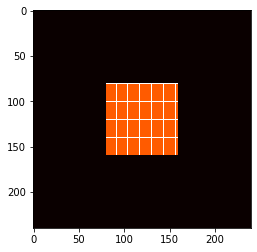

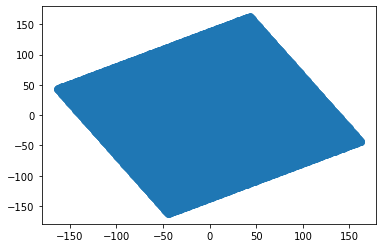

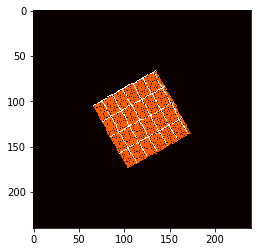

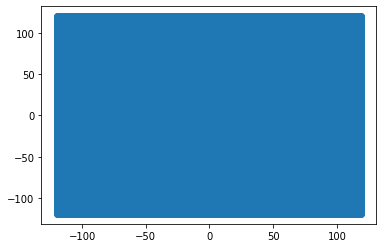

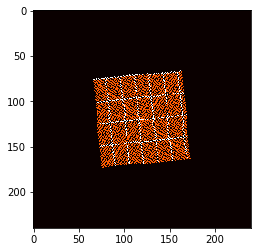

In [243]:
map = Map()
map.generate_map()
#map.display_map(mode="spacial")
map.display_map(mode="occupancy")

new_map = Map()
new_map.set_map(map.rigid_transform(0,0,np.pi/6))
new_map.display_map(mode="spacial")
new_map.display_map(mode="occupancy")

tmp_map = Map()
tmp_map.set_map(new_map.rigid_transform(0,0,-np.pi/6))
tmp_map.display_map(mode="spacial")
tmp_map.display_map(mode="occupancy")


## Acceptance metrics
the argreement between two maps is defined as: agr(M1, M2) which tells us the number of cells in each map that are both free or both occupied. the opposite is true for the disagreement index: dis(M1, M2).
  
The acceptance index between two maps is defined as: accept(M1, M2).  
0 -> if agr(M1, M2) = 0 and agr(M1,M2) / agr(M1,M2) + dis(M1, M2) if agr(M1,M2) != 0

use this to select different possible transformations. use some algo to maximize the acceptance index between two transforms.

In [98]:
def agr(m1: np.array([]), m2: np.array([])) -> int:
    # np arrays of CELLS
    assert m1.shape == m2.shape
    assert len(m1.shape) == 1
    
    agree = 0
    for i in range(m1.shape[0]):
        if m1[i].cell_state == States.Occupied and m2[i].cell_state == States.Occupied:
            agree += 1
        elif m1[i].cell_state == States.Free and m2[i].cell_state == States.Free:
            agree += 1
    return agree    

def dis(m1: np.array([]), m2: np.array([])) -> int:
    # np arrays of CELLS
    assert m1.shape == m2.shape
    assert len(m1.shape) == 1
    
    disagree = 0
    for i in range(m1.shape[0]):
        if m1[i].cell_state == States.Occupied and m2[i].cell_state != States.Occupied:
            disagree += 1
        elif m1[i].cell_state == States.Free and m2[i].cell_state != States.Free:
            disagree += 1
    return disagree

def accept(m1: np.array([]), m2: np.array([])) -> float:
    # np arrays of CELLS
    m1 = m1.flatten()
    m2 = m2.flatten()
    
    assert m1.shape == m2.shape
    assert len(m1.shape) == 1
    
    a = agr(m1, m2)
    d = dis(m1, m2)
    
    if a == 0:
        return 0.0
    else:
        return (a / (a + d))
    

In [8]:
accept(map.get_map(), new_map.get_map())

0.5925

## Orientation estimation based on Hough Specturm
Given a binary image we can use the Hough Transform to detect lines and geometric curves. Lines in the Hough Transform are in a polar representation.  
x*cos($\theta$) + y*sin($\theta$) = $\rho$  
$\rho$ is the distance of the line from the origin.  
$\theta$ is the angle between the x axis and the normal from the line to the origin.
    
Line detection is performed using the Discretized Hough Transform (DHT). DHT can be represented as a matrix of $\rho_s$ rows and $\theta_s$ columns. By setting all cells which are not occupied to white, we can process the map as an image, solving the DHT results $\HT_m$


In [192]:
from skimage.transform import hough_line, hough_line_peaks

def hough_image(map_array: np.array([])):
    image = np.zeros(map_array.shape)
    for i in range(image.shape[0]):
        for ii in range(image.shape[1]):
            if map_array[i,ii].cell_state == States.Occupied:
                image[i, ii] = 255
    return image

def hough_map_transform(image: np.array([])):
    tested_angles = np.linspace(0, 2*np.pi, 360, endpoint=False)
    h, theta, d = hough_line(image, theta=tested_angles)
    return h, theta, d
    
def render_hough_map_transform(map_array: np.array([])):
    image = hough_image(map_array)
    h, theta, d = hough_map_transform(image)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(image, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [np.rad2deg(theta[0] - angle_step),
              np.rad2deg(theta[-1] + angle_step),
              d[-1] + d_step, d[0] - d_step]
    ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    ax[2].imshow(image, cmap=cm.gray)
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

    plt.tight_layout()
    plt.show()

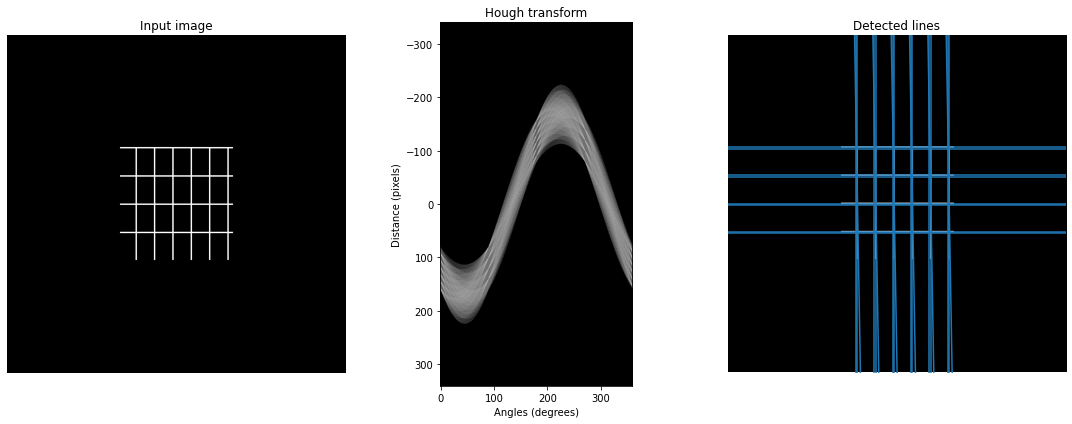

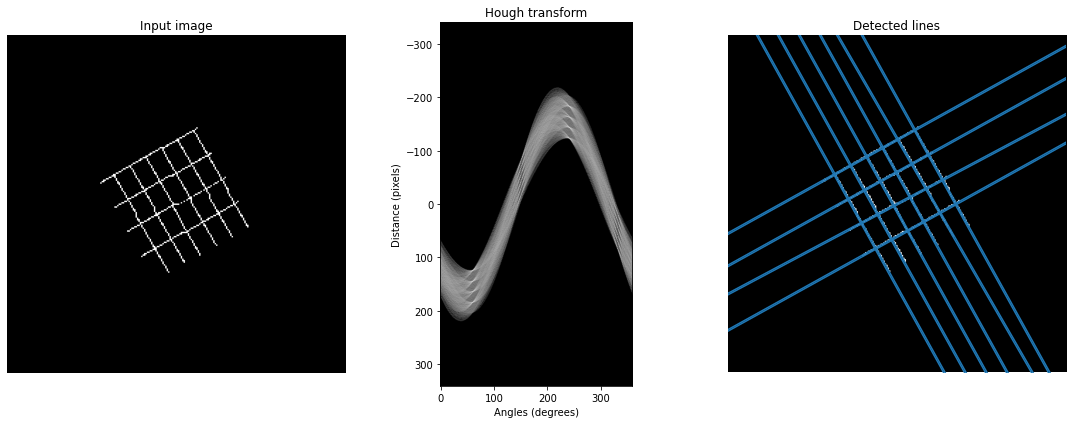

In [220]:
render_hough_map_transform(map.get_map())
render_hough_map_transform(new_map.get_map())

## Hough specturm
The signal is extend periodically for values of k outside the range 1 to $\theta_S$. From an intuitive point
of view, HSM indicates which directions are more frequent among lines detected in M. The following plots illustrate the hough spectrum as a line graph.

In [158]:
def hough_spectrum_calculation(map_array: np.array([])):
    image = hough_image(map_array)
    h, theta, d = hough_map_transform(image)
    spectrum = np.sum(np.square(h), axis=0)
    max = np.max(spectrum)
    spectrum = spectrum / max
    return spectrum

def render_hough_spectrum(spectrum: np.array([]), image: np.array([])):
    # rendering the image is optional
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    ax = axes.ravel()
    ax[0].imshow(image, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()
    
    ax[1].set_title('Hough Spectrum')
    ax[1].set_xlabel('angle (theta)')
    ax[1].set_ylabel('hough spectrum')
    ax[1].plot(spectrum)

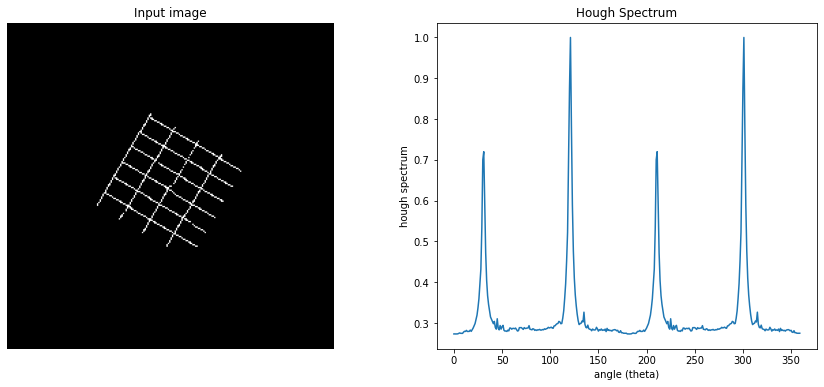

In [159]:
image = hough_image(new_map.get_map())
specturum = hough_spectrum_calculation(new_map.get_map())
render_hough_spectrum(specturum, image)

## Circular cross correlation
We can use cross correlation because Hough spectra are unidimentional signals. Cross correlation will identify similarities between two different maps. Hough spectra are defined through their orientations, thus we must calculate the circular cross correlation, making the signals radially comperable. If HSM1 and HSM2 are two Hough spectra with the same sampling period v then their circular cross correlation is a signal with the same sampling period.

https://inst.eecs.berkeley.edu/~ee16a/fa18/lectures/Note22.pdf

In [160]:
def circular_cross_correlation(HTM1: np.array([]), HTM2: np.array([])):
    CCMM = np.zeros(HTM1.shape)
    for k in range(HTM1.shape[0]):
        temp = 0.0
        for i in range(HTM1.shape[0]):
            temp += HTM1[i]*HTM2[(i+k)%HTM2.shape[0]]
        CCMM[k] = temp
    return CCMM
            

In [225]:
def FFT_circular_cross_correlation(HTM1, HTM2):
    # circular cross correlation done with FFT for O(n log N) time complexity
    Cross_correlation = np.fft.ifft(np.fft.fft(np.flip(HTM1)) * np.fft.fft(np.flip(HTM2)))
    return Cross_correlation / np.max(Cross_correlation)

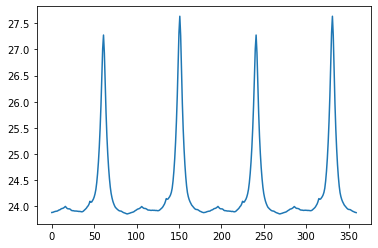

In [226]:
image = hough_image(map.get_map())
spectrum_1 = hough_spectrum_calculation(map.get_map())
spectrum_2 = hough_spectrum_calculation(new_map.get_map())
CCMM = circular_cross_correlation(spectrum_1, spectrum_2)
plt.plot(CCMM)

[297  28 208 207  27]


/home/peter/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


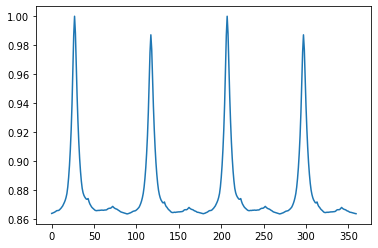

In [227]:
image = hough_image(map.get_map())
spectrum_1 = hough_spectrum_calculation(map.get_map())
spectrum_2 = hough_spectrum_calculation(new_map.get_map())
CCMM = FFT_circular_cross_correlation(spectrum_1, spectrum_2)
print(extract_local_maximums(CCMM, 5))
plt.plot(CCMM)

## Fast Displacement Computation.
The above methods provide us with the means to calculate cadidate rotations. We next need methods for solving candidate x and y translations. The translations needed to overlap M3 and M1 are obtained by extracting a number of spectral structures from the map images.  
The X-spectrum of a binary image M is a signal with a sampling period: SX(j) = { sum( M(i,j) ) where 1 <= j <= c. else 0. A similar equation is used for the Y-spectrum. Each of these act as a form of projection along the x and y axis. given the X-spectrum for two maps, a delta translation can be inferred using the cross correlation between each spectrum.

In [164]:
def axis_spectrum(axis: int, map_image: np.array([])) -> np.array([]):
    # axis defines which axis the spectrum is calculated on
    # axis = 0 -> x spectrum
    # axis = 1 -> y spectrum
    spect = np.sum(map_image, axis=axis)
    return spect / np.linalg.norm(spect)

In [165]:
def cross_correlation(m1_spectrum: np.array([]), m2_spectrum: np.array([])) -> np.array([]):
    cc = np.fft.ifft(np.fft.fft(m2_spectrum) * np.conjugate(np.fft.fft(m1_spectrum)))
    return cc/ np.linalg.norm(cc)

[104 105 116 106 117]
[130 156 117  91 104]


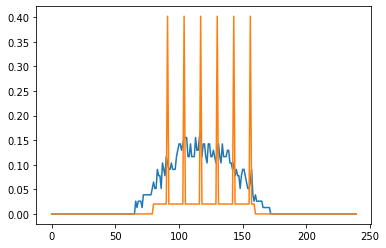

In [166]:
image_1 = hough_image(new_map.get_map())
spect = axis_spectrum(0, image_1)
print(extract_local_maximums(spect, 5))
plt.plot(spect)
image_2 = hough_image(map.get_map())
spect1 = axis_spectrum(0, image_2)
print(extract_local_maximums(spect1, 5))
plt.plot(spect1)

[0]


/home/peter/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


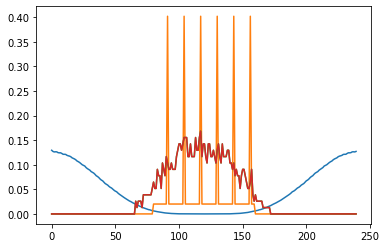

In [167]:
image_0 = hough_image(map.get_map())
spect_0 = axis_spectrum(0, image_0)
image_1 = hough_image(new_map.get_map())
spect_1 = axis_spectrum(0, image_1)
temp = Map()
temp.set_map(new_map.get_map())
image_2 = hough_image(temp.rigid_transform(0,0,0))
spect_2 = axis_spectrum(0, image_2)
cc = cross_correlation(spect_1, spect_2)
print(extract_local_maximums(cc, 1))
plt.plot(cc)
plt.plot(spect_0)
plt.plot(spect_1)
plt.plot(spect_2)

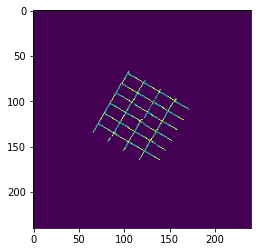

In [168]:
plt.imshow(image_1)

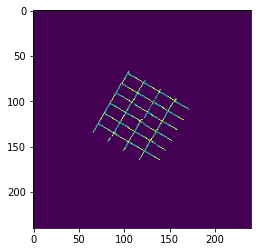

In [169]:
plt.imshow(image_2)

## Putting it all together
We will now produce a generic algorithm for merging two maps using the above processes.

In [239]:
def compute_hypothesis(map1, map2, num):
    """
    produces best possible accuracy merges given two maps
    """
    best_map = Map()
    best_acpt = -1
    
    HS_M1 = hough_spectrum_calculation(map1.get_map())
    HS_M2 = hough_spectrum_calculation(map2.get_map())
    CC_M1_M2 = FFT_circular_cross_correlation(HS_M1, HS_M2)
    local_max = extract_local_maximums(CC_M1_M2, num)
    
    map1_img = hough_image(map1.get_map())
    SX_M1 = axis_spectrum(0, map1_img)
    SY_M1 = axis_spectrum(1, map1_img)
    map3 = Map()   
    for rot in local_max:
        map3.set_map(map2.rigid_transform(0,0,math.radians(rot)))
        map3_img = hough_image(map3.get_map())
        SX_M3 = axis_spectrum(0, map3_img)
        SY_M3 = axis_spectrum(1, map3_img)

        CC_M1_M3_X = cross_correlation(SX_M1, SX_M3)
        CC_M1_M3_Y = cross_correlation(SY_M1, SY_M3)
        
        max_x = extract_local_maximums(CC_M1_M3_X, 1)[0]
        max_y = extract_local_maximums(CC_M1_M3_Y, 1)[0]
        
        cand_map = map3.rigid_transform(max_x, max_y, 0)
        acpt = accept(map1.get_map(), cand_map)
        
        print(max_x, max_y, rot, acpt)
        
        if acpt > best_acpt:
            best_acpt = acpt
            best_map.set_map(cand_map)
            
    return best_map

In [240]:
merged_map = compute_hypothesis(map, new_map, 5)

10 2 297 0.34328125
3 10 28 0.43359375
239 7 208 0.3509375
11 9 207 0.35515625
234 0 27 0.43625


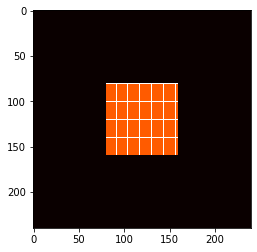

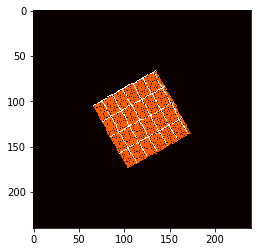

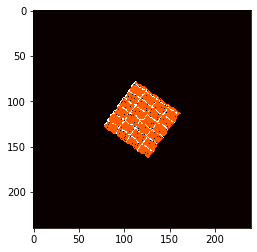

In [241]:
map.display_map()
new_map.display_map()
merged_map.display_map()